# Install & Import

In [14]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost.core")

In [15]:
import joblib
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_squared_log_error
import scipy.stats as stats
import time
from sklearn.model_selection import KFold
from statistics import geometric_mean
from imblearn.pipeline import Pipeline as ImbPipeline

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.mixed import (
    MixedVariableMating,
    MixedVariableSampling,
    MixedVariableDuplicateElimination,
)
from pymoo.core.problem import StarmapParallelization
from pymoo.optimize import minimize

import smogn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# def scorer_wrapper(func):
#     def wrapper(*args, **kwargs):
#         sample_weight = kwargs.get('sample_weight', None)
        
#         # If called with two arguments, assume they are (y_true, y_pred)
#         if len(args) == 2:
#             y_true, y_pred = args
            
#             # Jeśli podano wagi i funkcja to jedna ze standardowych metryk, obsłuż wagi
#             if sample_weight is not None:
#                 # Obsługa RMSE z wagami
#                 if func.__name__ == 'mean_squared_error' or func.__name__.endswith('mean_squared_error'):
#                     weighted_errors = sample_weight * ((y_true - y_pred) ** 2)
#                     return np.sqrt(np.sum(weighted_errors) / np.sum(sample_weight))
#                 # Obsługa MAE z wagami
#                 elif func.__name__ == 'mean_absolute_error' or func.__name__.endswith('mean_absolute_error'):
#                     weighted_errors = sample_weight * np.abs(y_true - y_pred)
#                     return np.sum(weighted_errors) / np.sum(sample_weight)
#                 # Obsługa R2 z wagami - bardziej skomplikowana, więc używamy sklearn jeśli to możliwe
#                 elif func.__name__ == 'r2_score' or func.__name__.endswith('r2_score'):
#                     return r2_score(y_true, y_pred, sample_weight=sample_weight)
            
#             return func(y_true, y_pred)
#         # If called with three arguments, assume they are (estimator, X, y)
#         elif len(args) == 3:
#             estimator, X, y = args
#             y_pred = estimator.predict(X)
            
#             if sample_weight is not None:
#                 if func.__name__ == 'mean_squared_error' or func.__name__.endswith('mean_squared_error'):
#                     weighted_errors = sample_weight * ((y - y_pred) ** 2)
#                     return np.sqrt(np.sum(weighted_errors) / np.sum(sample_weight))
#                 elif func.__name__ == 'mean_absolute_error' or func.__name__.endswith('mean_absolute_error'):
#                     weighted_errors = sample_weight * np.abs(y - y_pred)
#                     return np.sum(weighted_errors) / np.sum(sample_weight)
#                 elif func.__name__ == 'r2_score' or func.__name__.endswith('r2_score'):
#                     return r2_score(y, y_pred, sample_weight=sample_weight)
            
#             return func(y, y_pred)
#         else:
#             raise ValueError("Scorer function received an unexpected number of arguments.")
#     return wrapper
def weighted_mae_along_line(y_true, y_pred, weights):
    # Oblicz ważony błąd bezwzględny
    weighted_error = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
    return weighted_error / np.sqrt(2)


class DefaultSampler:
    def fit_resample(self, X, y):
        return X, y

class SMOGNSampler:
    def fit_resample(self, X, y):
        # Reset index to ensure continuous indexing for smogn
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        # Ensure that the target series has a valid name; if not, assign one.
        if y.name is None:
            y = y.rename("target")
        df = pd.concat([X, y], axis=1)
        df_resampled = smogn.smoter(data=df, y=y.name)
        y_resampled = df_resampled[y.name]
        X_resampled = df_resampled.drop(columns=[y.name])
        return X_resampled, y_resampled

# Settings/Constant variables

In [16]:
# Constant Variables
CPU_CORES_COUNT = 14
RND_STATE = 37

TRAIN_TEST_SPLIT = 0.05
BALANCER_SCORER = 'rmse'
HYPERPARAM_TUNING_SCORER = 'rmse'
HYPERPARAM_TUNING_NFOLDS = 7

HYPERPARAM_TUNING_POPSIZE = 24
# TERMINATION = ("n_gen", 10)
TERMINATION = ("time", "06:00:00")

DATASET_FILENAME = "reg_default_modeling.csv"
# BALANCE_METHOD = ''

In [17]:
SCORERS = {
    'rmse': lambda y_true, y_pred, sample_weight=None: np.sqrt(
        mean_squared_error(y_true, y_pred, sample_weight=sample_weight)
    ),
    'mae': lambda y_true, y_pred, sample_weight=None: mean_absolute_error(
        y_true, y_pred, sample_weight=sample_weight
    ),
    'r2': lambda y_true, y_pred, sample_weight=None: r2_score(
        y_true, y_pred, sample_weight=sample_weight
    )
}

OBJ_EVAL_METRICS = {
    'reg:squarederror': 'rmse',
    'reg:squaredlogerror': 'rmsle',
    'reg:gamma': 'gamma-deviance',
    'reg:tweedie': 'tweedie-nloglik',
    'reg:pseudohubererror': 'mphe',
    'count:poisson': 'poisson-nloglik'
}
BALANCE_METHODS = {
    "default": DefaultSampler(),  # No sampling.
    "random_over": RandomOverSampler(random_state=RND_STATE),  # Random over-sampling.
    "random_under": RandomUnderSampler(random_state=RND_STATE),  # Random under-sampling.
    "smogn": SMOGNSampler(),  # SMOGN for regression.
}

# Read data

In [18]:
# Read the dataset
modeling = pd.read_csv(f"data/{DATASET_FILENAME}")

In [19]:
X = modeling.drop(['target', 'weight'], axis=1)
y = modeling['target']
w = modeling['weight']

In [20]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=TRAIN_TEST_SPLIT, random_state=RND_STATE
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9732, 381), (513, 381), (9732,), (513,))

# Default model

## Train

In [21]:
default_xgb_model = xgb.XGBRegressor(device="cuda",
                                     seed=RND_STATE,
                                     tree_method='hist',
                                     verbosity=2,
                                    )

default_xgb_model.fit(X_train, 
                      y_train, 
                      sample_weight=w_train
                     )
joblib.dump(default_xgb_model, "models/default_reg_model.joblib")

['models/default_reg_model.joblib']

In [22]:
y_pred = default_xgb_model.predict(X_test)

# Calculate residuals between actual and predicted values
# residuals = y_test - y_pred
residuals = np.sqrt(w_test) * (y_test - y_pred)

## Examine results

In [23]:
for name, scorer in SCORERS.items():
    print(f'{name} {scorer(y_test, y_pred)}')

rmse 1.6483789911425664
mae 1.1909769148331257
r2 0.12443265384553603


In [24]:
weighted_mae_along_line(y_test, y_pred, w_test)

0.9448712508794497

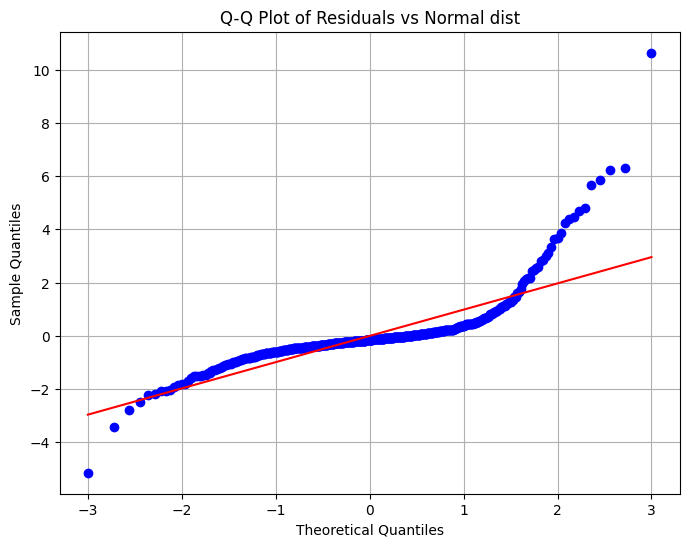

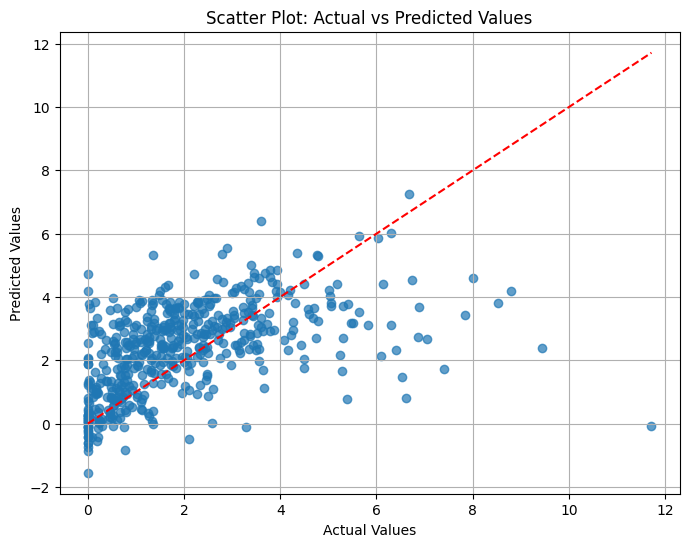

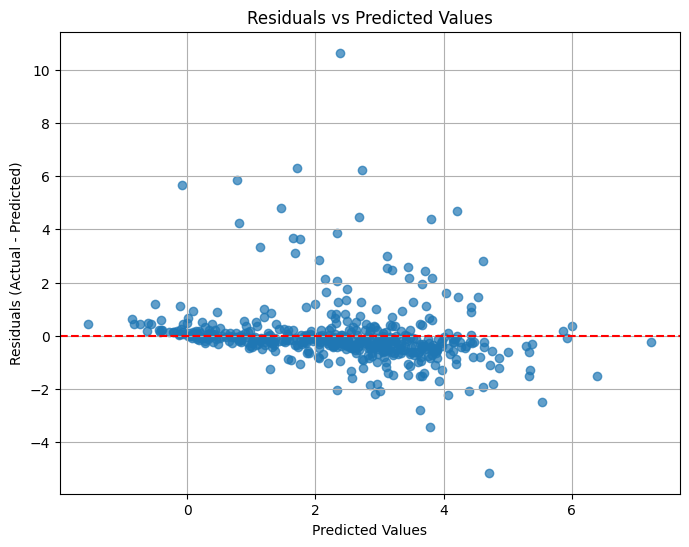

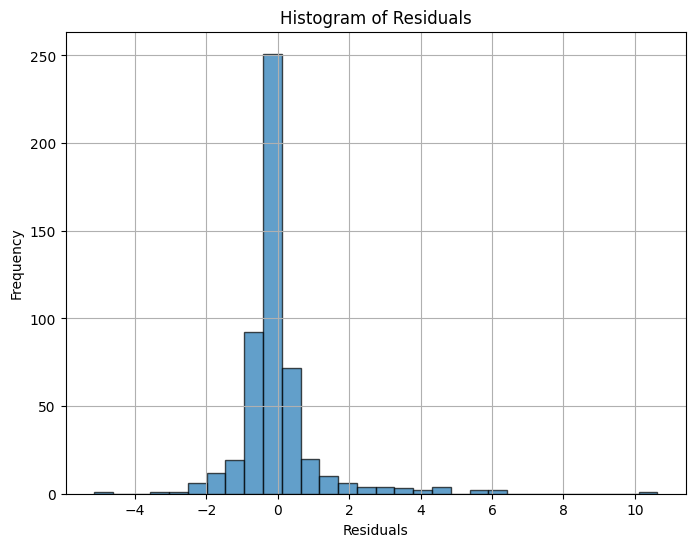

In [25]:
# Create a Q-Q plot for the residuals to assess their normality
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals vs Normal dist")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# 1. Scatter Plot: Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs Predicted Values')
plt.grid(True)
plt.show()

# 2. Residuals vs Predicted Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

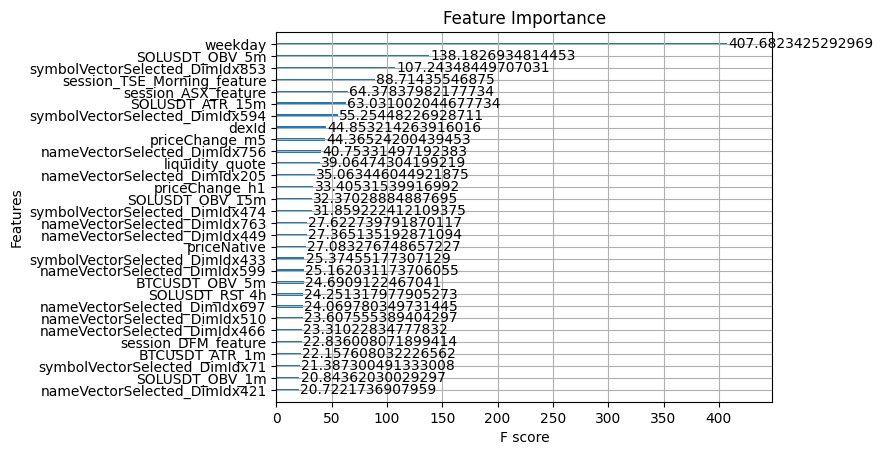

In [26]:
# Plot feature importance using the trained model
plt.figure(figsize=(10, 8))
xgb.plot_importance(default_xgb_model, importance_type='gain', max_num_features=30)
plt.title("Feature Importance")
plt.show()

# Hiperparameter optimization

## Define problem class

In [27]:
class XGBoostOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, w_data, scorer, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.w_data = w_data
        self.cv_folds = cv_folds
        self.scorer = scorer # Should be R^2
        self.rnd_state = rnd_state
        self.eval_times = []

        self.kf = KFold(n_splits=cv_folds, shuffle=True, random_state=rnd_state)
        
        hyperparameters = {
            # Podstawowe parametry uczenia
            "learning_rate": Real(bounds=(0.001, 0.3)),
            "n_estimators": Integer(bounds=(100, 2000)),
            # "early_stopping_rounds": Integer(bounds=(5, 50)),
            
            # Parametry kontrolujące strukturę drzewa
            "max_depth": Integer(bounds=(2, 12)),
            "min_child_weight": Integer(bounds=(1, 20)),
            "max_delta_step": Integer(bounds=(0, 10)),
            "gamma": Real(bounds=(0, 10)),
            
            # Parametry próbkowania
            "subsample": Real(bounds=(0.5, 1.0)),
            "colsample_bytree": Real(bounds=(0.1, 1.0)),
            "colsample_bylevel": Real(bounds=(0.2, 1.0)),
            "colsample_bynode": Real(bounds=(0.2, 1.0)),
            
            # Parametry regularyzacji
            "reg_alpha": Real(bounds=(0, 50)),
            "reg_lambda": Real(bounds=(0, 50)),
            
            # Dodatkowe parametry (nowe)
            "grow_policy": Choice(options=["depthwise", "lossguide"]),
            "max_leaves": Integer(bounds=(0, 256)),
            "max_bin": Integer(bounds=(32, 512)),
            
            # Funkcja celu
            "objective": Choice(options=[
                'reg:squarederror', 
                'reg:squaredlogerror', 
                'reg:gamma', 
                'reg:tweedie', 
                'reg:pseudohubererror', 
                'count:poisson'
            ]),

            "tweedie_variance_power": Real(bounds=(1, 2)),
        }
        
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        if X["objective"] != 'reg:tweedie':
            eval_metric = OBJ_EVAL_METRICS[X["objective"]]
        else:
            eval_metric = f"tweedie-nloglik@{X['tweedie_variance_power']}"
        start_time = time.time()
        scores = []
        
        # Pętla CV ręcznie, aby wykorzystać early stopping
        for train_index, valid_index in self.kf.split(self.x_data):
        # Use .iloc to index rows by integer positions instead of column names
            X_train_fold = self.x_data.iloc[train_index]
            y_train_fold = self.y_data.iloc[train_index]
            w_train_fold = self.w_data.iloc[train_index]
    
            X_valid_fold = self.x_data.iloc[valid_index]
            y_valid_fold = self.y_data.iloc[valid_index]
            w_valid_fold = self.w_data.iloc[valid_index]
            
            model = xgb.XGBRegressor(
                device="cuda",
                tree_method='hist',
                random_state=self.rnd_state,
                eval_metric=eval_metric,
                **X
            )
            
            model.fit(
                X_train_fold, 
                y_train_fold, 
                sample_weight=w_train_fold,
                # eval_set=[(X_valid_fold, y_valid_fold)],
                # eval_sample_weight=[w_valid_fold],
                # early_stopping_rounds=X["early_stopping_rounds"],
                verbose=False
            )
            y_pred_fold = model.predict(X_valid_fold)

            # # Compute residuals (unstandardized)
            # residuals = y_valid_fold - y_pred_fold
            
            # # Estimate the density of unstandardized residuals using KDE
            # kde = gaussian_kde(residuals)
            # kde_density = kde(residuals)
            
            # # Compute standard deviation from residuals
            # std_res = np.std(residuals)
            
            # # Compute the reference density from a normal distribution with mean=0 and std computed from residuals
            # normal_density = norm.pdf(residuals, loc=0, scale=std_res)
            
            # # Compute the KL divergence using Monte Carlo integration (via sample mean)
            # epsilon = 1e-10  # Small value to avoid log(0)
            # kl_distance = np.mean(np.log((kde_density + epsilon) / (normal_density + epsilon)))
            
            # # For evaluation, lower KL divergence is better, so we return its negative (i.e. higher score means better fit)
            # score_fold = kl_distance

            # distance = np.mean(np.abs(y_pred_fold - y_valid_fold) / np.sqrt(2))
            # print(f'distance {distance}')
            # Xs, yk = y_pred_fold.reshape(-1, 1), y_valid_fold-y_pred_fold
            # X_design = np.hstack((np.ones((Xs.shape[0], 1)), Xs))

            # # Compute the regression coefficients using the normal equation.
            # coefficients = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_design.T, X_design)), X_design.T), yk)
            
            # # Unpack the coefficients: intercept and slope.
            # matrix_intercept, matrix_slope = coefficients.ravel()
            
            # print(f'matrix_intercept: {matrix_intercept}, matrix_slope: {matrix_slope}')
            
            # lin_reg =  LinearRegression().fit(y_pred_fold.reshape(-1, 1), y_valid_fold-y_pred_fold)
            # slope, intercept = lin_reg.coef_[0], lin_reg.intercept_
            # print(f'intercept {intercept} slope {slope}')
            
            # distance = np.abs(intercept) / np.sqrt(1 + slope**2)
            # print(f"Distance from regression line to y = 0: {distance:.4f}")

            score_fold = weighted_mae_along_line(y_valid_fold, y_pred_fold, w_valid_fold)
            # score_fold = self.scorer(y_valid_fold, y_pred_fold, sample_weight=w_valid_fold)
            scores.append(score_fold)

        # As arthmetic >= geomethirc >= harmonic (means)
        # It's better to use arthmetic when using distance scorer with regression problem
        print(f'scores {scores}')
        mean_score = np.mean(scores)
        # mean_score = geometric_mean(scores) does not work with <=0
        # mean_score = 0 if (np.array(scores) <= 0).any() else len(np.array(scores)) / np.sum(1 / np.array(scores))
        
        eval_time = time.time() - start_time
        self.eval_times.append(eval_time)
        print(f'Params: {X}')
        # print(f'scores {scores}')
        print(f'Mean CV score: {mean_score}  Evaluation time: {eval_time:.2f}s (mean {np.mean(self.eval_times):.2f}s)')
        print()
        out["F"] = mean_score

## Run search

In [28]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = XGBoostOptimizationProblem(
    X_train,
    y_train,
    w_train,
    cv_folds=HYPERPARAM_TUNING_NFOLDS,
    scorer=SCORERS[HYPERPARAM_TUNING_SCORER],
    rnd_state=RND_STATE
)
algorithm = GA(
    pop_size=HYPERPARAM_TUNING_POPSIZE,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=TERMINATION,
    verbose=True,
)

scores [1.0786123122728266, 0.965124955801586, 1.1715646353749674, 1.0499693246083688, 1.0097647573997002, 1.0208306707357966, 0.9975387230495052]
Params: {'learning_rate': 0.07533307352267778, 'n_estimators': 309, 'max_depth': 9, 'min_child_weight': 8, 'max_delta_step': 4, 'gamma': 2.0513885436538026, 'subsample': 0.6938967201724888, 'colsample_bytree': 0.6787759133299776, 'colsample_bylevel': 0.5940802713965405, 'colsample_bynode': 0.4143059684075045, 'reg_alpha': 37.74796563524293, 'reg_lambda': 11.824304079027492, 'grow_policy': 'lossguide', 'max_leaves': 173, 'max_bin': 337, 'objective': 'reg:pseudohubererror', 'tweedie_variance_power': 1.4492373194252446}
Mean CV score: 1.041915054177536  Evaluation time: 13.34s (mean 13.34s)

scores [1.160360855399021, 1.1219126120760567, 1.3218346750192456, 1.1870689787652586, 1.1814461935700131, 1.1333043975105976, 1.2103601666109352]
Params: {'learning_rate': 0.15765375756262592, 'n_estimators': 835, 'max_depth': 10, 'min_child_weight': 9, 'm

In [29]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: score= {res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: score= {res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

Best gene: score= 0.966935248001942 variables= dict_items([('learning_rate', 0.0091101558481686), ('gamma', 0.7672188270803121), ('subsample', 0.8343903794468948), ('colsample_bytree', 0.5899521199202259), ('colsample_bylevel', 0.8525469963297396), ('colsample_bynode', 0.8806346643889965), ('reg_alpha', 3.4245105513299556), ('reg_lambda', 34.48071177656628), ('tweedie_variance_power', 1.4810024377895719), ('n_estimators', 1936), ('max_depth', 7), ('min_child_weight', 7), ('max_delta_step', 1), ('max_leaves', 72), ('max_bin', 307), ('grow_policy', 'depthwise'), ('objective', 'reg:squarederror')])


## Fit tuned model

In [30]:
if res.X["objective"] != 'reg:tweedie':
    eval_metric = OBJ_EVAL_METRICS[res.X["objective"]]
else:
    eval_metric = f"tweedie-nloglik@{res.X['tweedie_variance_power']}"

tuned_xgb_model = xgb.XGBRegressor(device="cuda",
                                seed=RND_STATE,
                                eval_metric=eval_metric,
                                tree_method='hist',
                                verbosity=2,
                                **res.X
                               )

tuned_xgb_model.fit(X_train, 
                    y_train, 
                    sample_weight=w_train,
                   )
joblib.dump(tuned_xgb_model, "models/tuned_reg_model.joblib")

[10:03:41] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:139: Generating new Ellpack page.


['models/tuned_reg_model.joblib']

In [31]:
y_pred = tuned_xgb_model.predict(X_test)

# Calculate residuals between actual and predicted values
residuals = y_test - y_pred

In [32]:
# sorted(y_pred, reverse=True)
np.quantile(y_pred, [0.25, 0.5, 0.75, 0.95, 0.99, 1.])

array([1.69294631, 2.75475907, 3.44036222, 4.22001648, 4.86308195,
       6.63496113])

In [33]:
np.mean(y_pred)

2.5520105

## Examine results

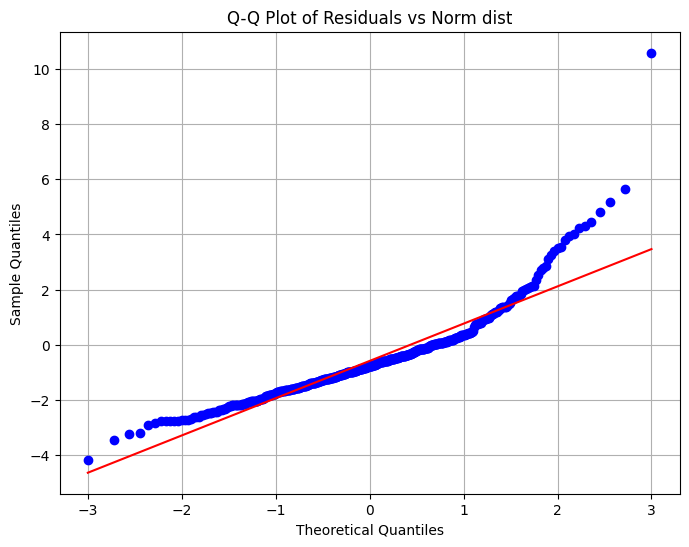

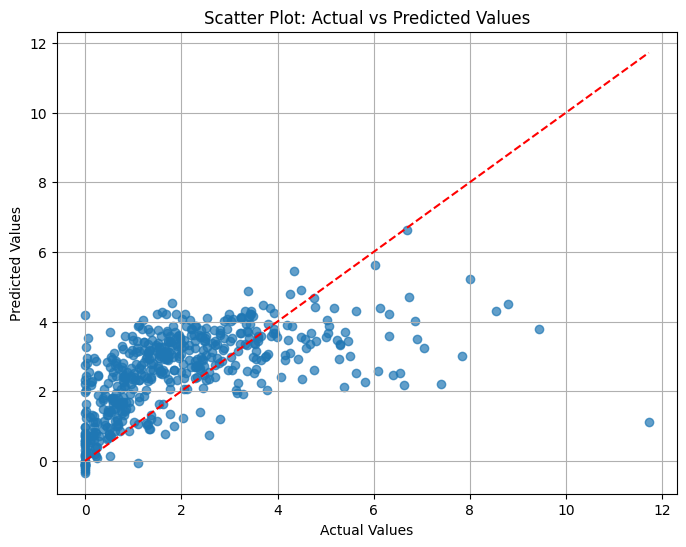

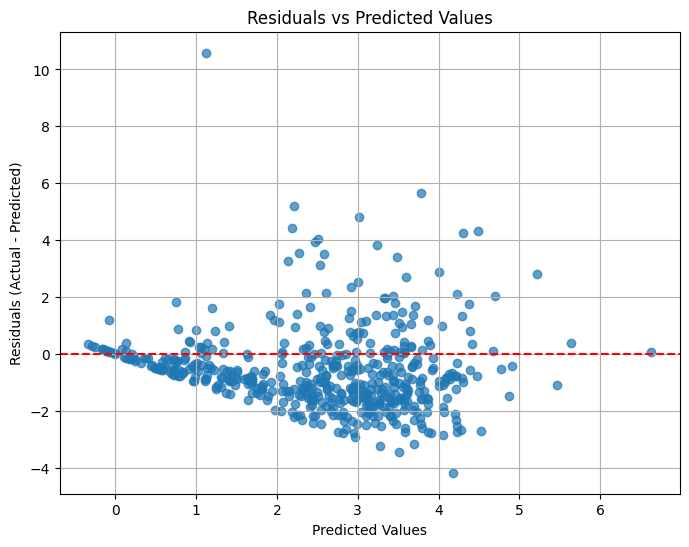

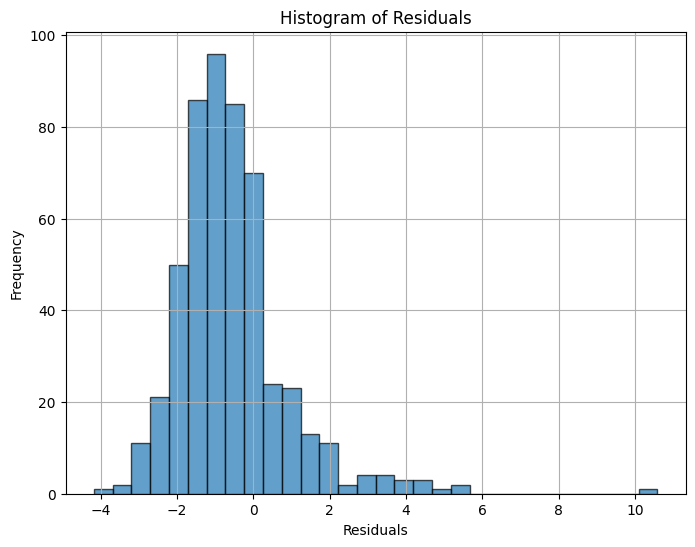

In [34]:
# Create a Q-Q plot for the residuals to assess their normality
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals vs Norm dist")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# 1. Scatter Plot: Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs Predicted Values')
plt.grid(True)
plt.show()

# 2. Residuals vs Predicted Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

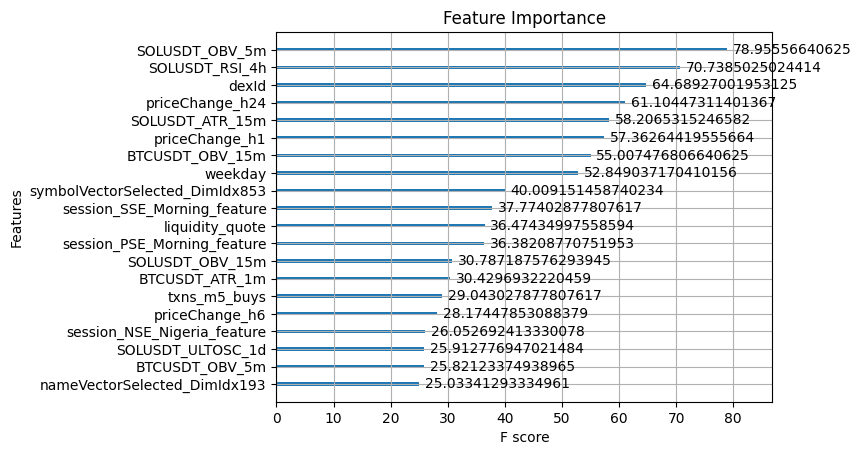

In [35]:
# Plot feature importance using the trained model
plt.figure(figsize=(10, 8))
xgb.plot_importance(tuned_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")
plt.show()

# Final model

In [36]:
X_train_final, X_test_final, y_train_final, y_test_final, w_train_final, w_test_final = train_test_split(
    X, y, w, test_size=0.01, random_state=RND_STATE
)

## Train

In [37]:
if res.X["objective"] != 'reg:tweedie':
    eval_metric = OBJ_EVAL_METRICS[res.X["objective"]]
else:
    eval_metric = f"tweedie-nloglik@{res.X['tweedie_variance_power']}"

final_xgb_model = xgb.XGBRegressor(device="cuda",
                                seed=RND_STATE,
                                eval_metric=eval_metric,
                                tree_method='hist',
                                verbosity=2,
                                **res.X
                               )

final_xgb_model.fit(X_train_final, 
                    y_train_final, 
                    sample_weight=w_train_final,
                    # eval_set=[(X_test_final, y_test_final)]
                   )
joblib.dump(final_xgb_model, "models/final_reg_model.joblib")

[10:04:10] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:139: Generating new Ellpack page.


['models/final_reg_model.joblib']

In [38]:
y_pred = final_xgb_model.predict(X_test_final)

# Calculate residuals between actual and predicted values
residuals = y_test_final - y_pred

## Examine results

In [39]:
# sorted(y_pred, reverse=True)
np.quantile(y_pred, [0.25, 0.5, 0.75, 0.95, 0.99, 1.])

array([1.72127753, 2.79461145, 3.43566358, 4.27468791, 4.66899716,
       5.15500021])

In [40]:
np.mean(y_pred)

2.579946

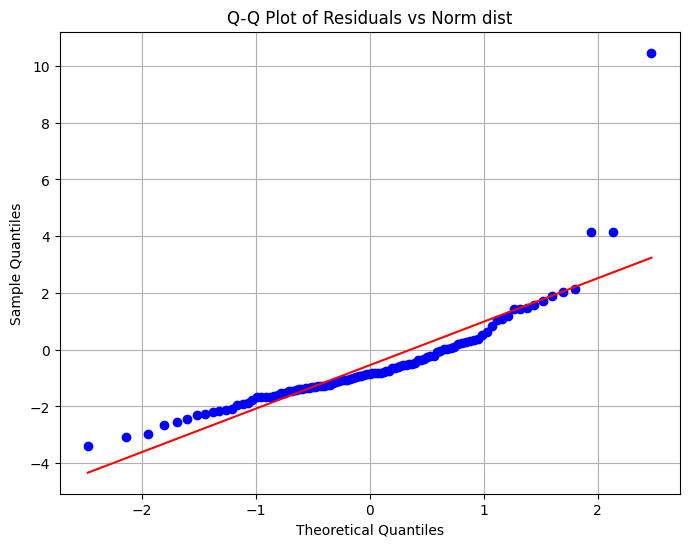

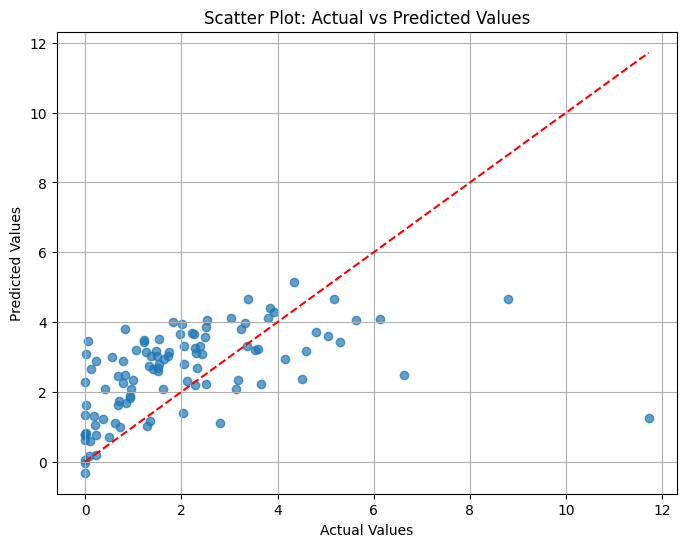

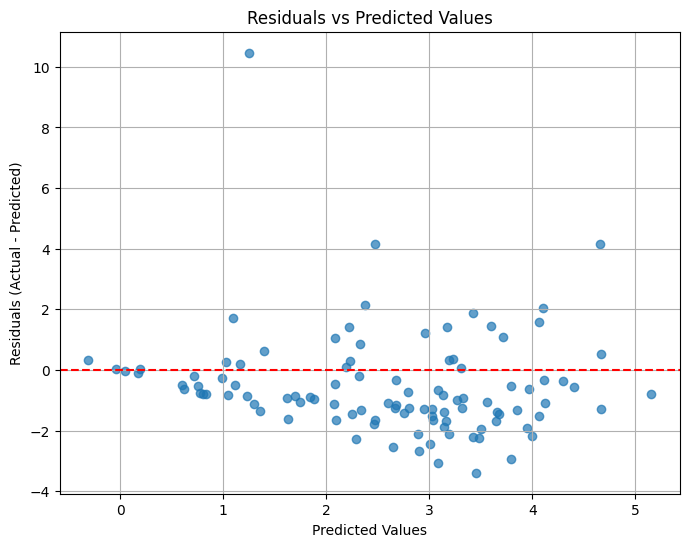

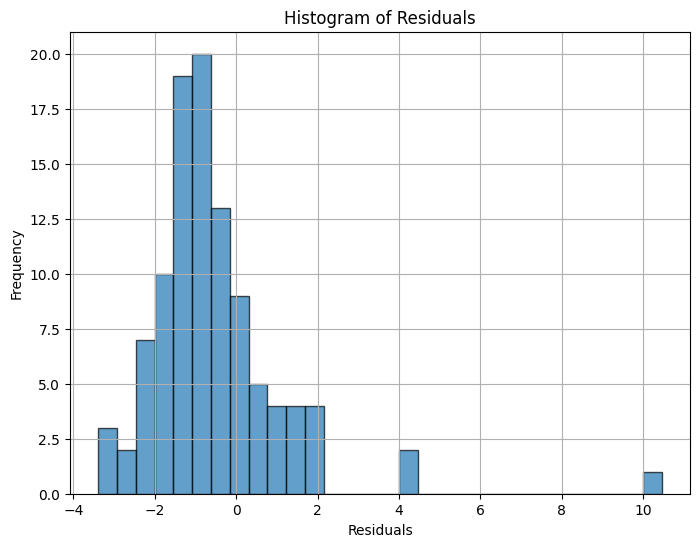

In [41]:
# Create a Q-Q plot for the residuals to assess their normality
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals vs Norm dist")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

# 1. Scatter Plot: Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_final, y_pred, alpha=0.7)
plt.plot([min(y_test_final), max(y_test_final)], [min(y_test_final), max(y_test_final)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot: Actual vs Predicted Values')
plt.grid(True)
plt.show()

# 2. Residuals vs Predicted Values Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

# 3. Histogram of Residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

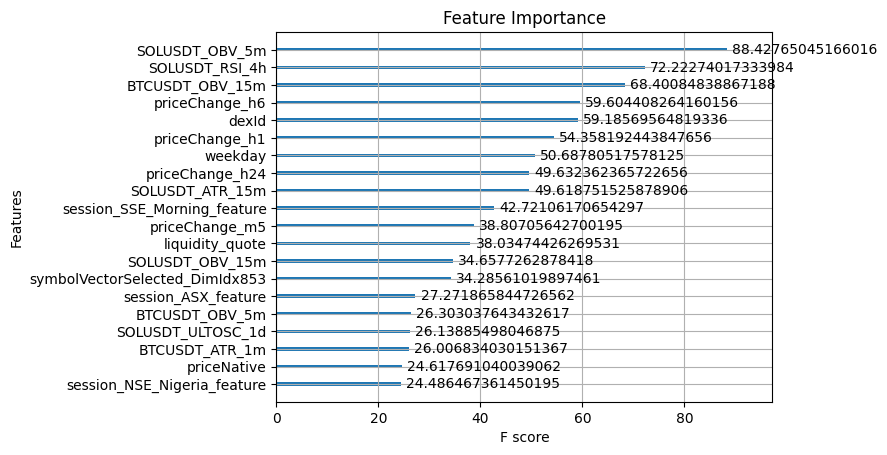

In [42]:
# Plot feature importance using the trained model
plt.figure(figsize=(10, 8))
xgb.plot_importance(final_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")
plt.show()

# Optimize dataset balancer

## Run search

In [43]:
# best_metric = -1
# best_method = None
# best_pipeline = None
# results = []

# for method_name, sampler in BALANCE_METHODS.items():
#     pipeline = ImbPipeline([
#         ('sampler', sampler),
#         ('model', xgb.XGBRegressor(device="cuda",
#                                 seed=RND_STATE,
#                                 eval_metric='rmse',
#                                 tree_method='hist',
#                                 verbosity=2,
#                                 **res.X
#                                ))
#     ])
    
#     cv = KFold(n_splits=5, shuffle=True, random_state=RND_STATE)
    
#     cv_results = cross_validate(
#         estimator=pipeline,
#         X=X_train,
#         y=y_train,
#         cv=cv,
#         scoring=SCORERS,
#         return_train_score=False,
#         n_jobs=1
#     )
#     mean_scores = {
#         'rmse': np.mean(cv_results['test_rmse']),
#         'mae': np.mean(cv_results['test_mae']),
#         'r2': np.mean(cv_results['test_r2'])
#     }
    
#     results.append({
#         "Method": method_name,
#         **mean_scores
#     })
    
#     print(f"Metoda: {method_name}")
#     print(f"CV rmse: {mean_scores['rmse']:.4f}, mae: {mean_scores['mae']:.4f}, r2: {mean_scores['r2']:.4f}\n")
    
#     if mean_scores[BALANCER_SCORER] > best_metric:
#         best_metric = mean_scores[BALANCER_SCORER]
#         best_method = method_name
#         best_pipeline = pipeline

## Examine results

In [44]:
# # Podsumowanie wyników
# balancer_results = pd.DataFrame(results).sort_values(by=BALANCER_SCORER, ascending=False)
# print("\nPodsumowanie wyników walidacji krzyżowej:")
# print(balancer_results)

In [45]:
# # Predict on the test set
# y_pred = tuned_xgb_model.predict(X_test)
# y_pred_proba = tuned_xgb_model.predict_proba(X_test)[:, 1]

# # Calculate evaluation metrics
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, zero_division=0)
# recall = recall_score(y_test, y_pred, zero_division=0)
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# pr_auc = average_precision_score(y_test, y_pred_proba)
# mcc = matthews_corrcoef(y_test, y_pred)
# balanced_acc = balanced_accuracy_score(y_test, y_pred)

# # Print the metrics
# print("SCORES:")
# print(f"F1 Score:          {f1:.4f}")
# print(f"MCC:               {mcc:.4f}")
# print(f"PR AUC:            {pr_auc:.4f}")
# print(f"Balanced Accuracy: {balanced_acc:.4f}")
# print(f"Precision:         {precision:.4f}")
# print(f"Recall:            {recall:.4f}")
# print(f"AUC:               {roc_auc:.4f}")

# # Display confusion matrix and classification report
# cm = confusion_matrix(y_test, y_pred)
# print("\nConfusion Matrix:")
# print(cm)
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Plot confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.title("Confusion Matrix")
# plt.show()

# # Plot ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
# roc_auc_curve = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc_curve:.2f})")
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend(loc="lower right")
# plt.show()

In [46]:
# plt.figure(figsize=(10, 8))
# plot_importance(
#     tuned_xgb_model, max_num_features=25, importance_type="weight", show_values=True
# )
# plt.title("Top 20 Most Important Features (XGBoost)")
# plt.show()